# Imports

In [1]:
# General
import pandas as pd
import numpy as np
import os
import custom_functions as cf

# Plotting
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback

In [2]:
# Get rid of annoying LGBM messages
import warnings
warnings.filterwarnings("ignore", message="categorical_column in param dict is overridden.")
warnings.filterwarnings("ignore", message='Overriding the parameters from Reference Dataset.')
warnings.filterwarnings("ignore", message='The reported value is ignored because this*')
warnings.filterwarnings("ignore", message='Found `n_estimators` in params. Will use it*')
warnings.filterwarnings("ignore", message='The distribution is specified by*')

# Hide optuna logging too
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Hide keras gpu message
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

In [3]:
# Set plotting config
cf.set_plot_config()

In [4]:
# Read in data
data = pd.read_csv("music_data.csv")
# Get number of classes
n_classes = data.playlist_genre.nunique()
# Select the target variable
y = data.playlist_genre

# Split into stratified (since uneven classes) test and train data
train_raw, test_raw = train_test_split(data, test_size = 0.2,
                                       shuffle = True, random_state = 42, # random, reproducible split
                                       stratify = data.playlist_genre)

# Pre-processing

- <b>Run dimension reduction over the (highly sparse) lyric features, using either Principal Component Analysis, Truncated Singular Value Decomposition or a Keras autoencoder
- <b>Normalise all features between 0 and 1 (except for categorical features, mode and key).
- <b>Convert the y/label data from text to numbers, e.g. rock = 0, pop = 1

In [5]:
# Set up dimension reduction threshold, e.g. how many dimensions to reduce lyric features to (1806 is max)
n_components = 1500
# Select the dimension reduction method to use: "pca", "svd" or "keras"
reduction_method = "svd" # If keras is used, this will take a long time to run
# Pre-process data
X_train, y_train, X_test, y_test, label_encoder = cf.pre_process(train_raw, test_raw,
                                                      reduction_method = reduction_method,
                                                     n_components = n_components)

# Modelling

In [6]:
# Params to compile model with
fixed_params = {
        'objective': 'multiclass',
        'metric': "None",   # Set as none so that custom f1 metric can be used
        'num_class': 5,
        'verbosity': -1,
}
# Select how many trials to run for in Optuna
n_trials = 200

## First Round Hyperparam Tuning

<b> 1st round of hyperparameter tuning, set the range of values to try (e.g. trial.suggest_float(lower_bound, upper_bound)) to be quite wide initially. Look at the subsequent plots and see what areas of the hyperparameter search space resulted in the best performances.

In [7]:
def objective(trial, X, y):
    """
    Wrapper function to work with Optuna trial objects, 
    enabling Hyperband hyperparameter search.
    """
    # Set seed for reproducibility
    cf.set_seed()
    
    # Suggest hyperparams to test using Optuna trial object.
    param = {**fixed_params,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 3000, step = 20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.99, step = 0.05),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.2, 0.99, step = 0.05),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        "n_estimators": trial.suggest_int("n_estimators", 200, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 2000, step=5),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 10),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
    }
    
    # Create cv object
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    # Make empty array to store cv f1 scores in
    cv_scores = np.empty(5)
    
    # Split into K train and validation sets and iterate through them
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Split into training and validation CV sets
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        # Convert data to proper LGBM format
        train_data = lgb.Dataset(X_train_cv, label = y_train_cv, categorical_feature="auto")
        val_data = lgb.Dataset(X_test_cv, label = y_test_cv,  categorical_feature="auto",
                              reference = train_data)
        
        # Make callbacks to prevent trialling hyperparams that are obviously bad
        callbacks = [
            LightGBMPruningCallback(trial, metric = "f1_score"),
                     # Callback to reduce model validation performance messages
                    lgb.log_evaluation(period = 100),
                     # Early stoppping to prevent overfitting training data
                    lgb.early_stopping(50)]

        # Training the model
        model = lgb.train(params = param,  train_set = train_data,
                          valid_sets = val_data,   
                          callbacks = callbacks,
                          feval = cf.lgb_f1_score # use custom eval metric to optimize against
                         )
        
        # Get predictions
        preds = np.argmax(model.predict(X_test_cv), axis = 1)
        # Calculate F1 Score
        cv_scores[idx] = f1_score(y_test_cv, preds, average = "macro")

    return np.mean(cv_scores)

In [8]:
%%capture first_round
# Above line magic hides lengthy output, but stores into first_round if you want to look

# Set seed for reproducibility
cf.set_seed()
# Create Optuna study to do CV hyperparameter search
study = optuna.create_study(direction = "maximize", # maximising CV F1 score
                            study_name = "LGBM Classifier",
                           pruner=optuna.pruners.HyperbandPruner())
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials = n_trials)

In [9]:
# Let's you see output from LGBM trials if needed
# first_round()

### Analyse Results

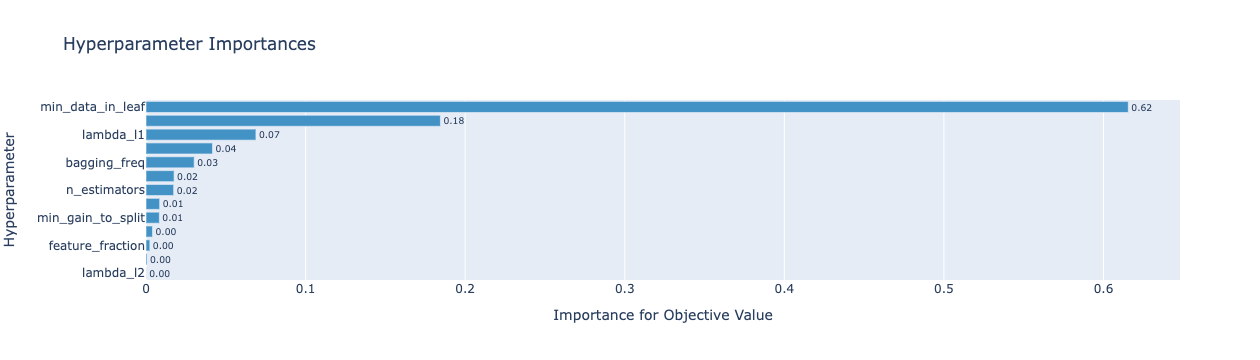

In [10]:
# Compare hyperparameter importances
plot_param_importances(study)

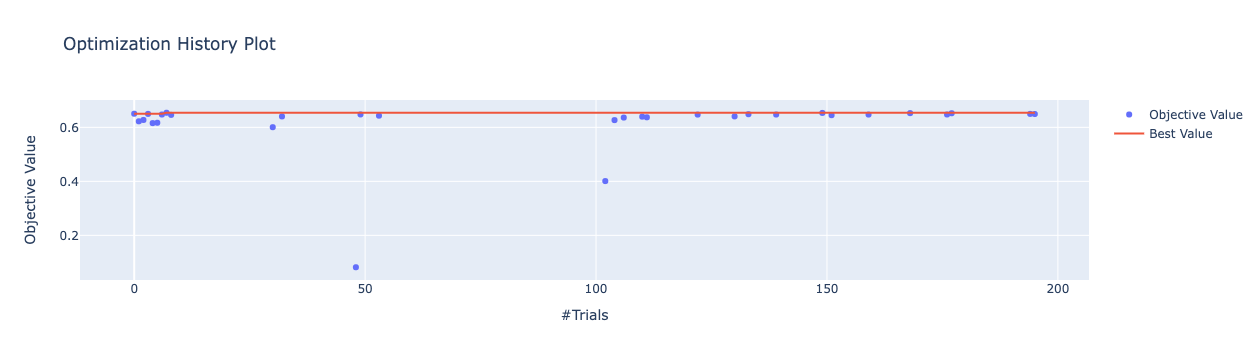

In [11]:
# Show optimization history
plot_optimization_history(study)

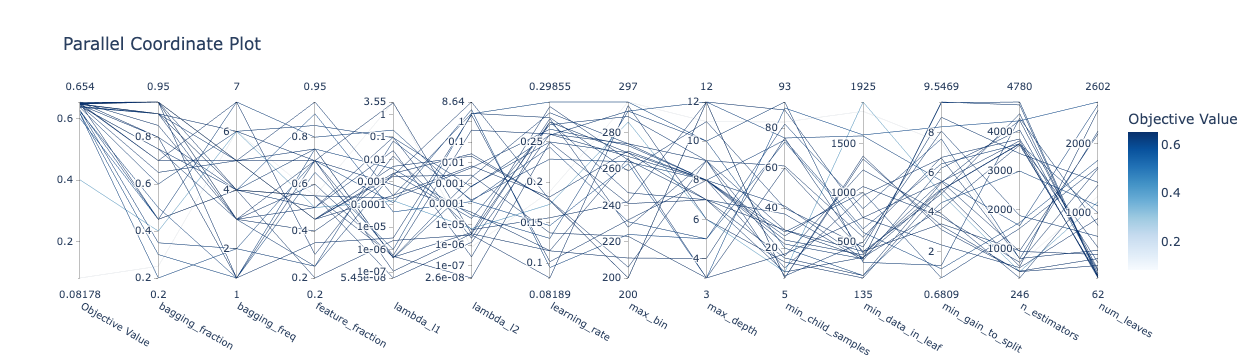

In [12]:
# Plot different combinations of hyperparams to see which in which ranges fared best
plot_parallel_coordinate(study)

In [13]:
# Current
study.best_value

0.6539972789582378

In [14]:
# Current
study.best_params

{'num_leaves': 2482,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'min_child_samples': 75,
 'n_estimators': 544,
 'learning_rate': 0.11533338499059735,
 'max_depth': 4,
 'min_data_in_leaf': 385,
 'lambda_l1': 3.2932893588525327,
 'lambda_l2': 3.613309232632257e-06,
 'min_gain_to_split': 5.174610977945456,
 'max_bin': 211}

## Second Round Hyperparameter Tuning

<b>Now tweak the Optuna Trial suggestions to narrow the search space to be closer around the previously optimal hyperparam values

In [15]:
def objective_tuned(trial, X, y):
    """
    Wrapper function to work with Optuna trial objects, 
    enabling Hyperband hyperparameter search.
    """
    # Set seed for reproducibility
    cf.set_seed()
    
    # Suggest hyperparams to test using Optuna trial object.
    param = {**fixed_params,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 500, 2000, step = 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.88,),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 0.99),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 120),
        "n_estimators": trial.suggest_int("n_estimators", 200, 5000),
        "learning_rate": trial.suggest_float("learning_rate", 0.003, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 25, 1000),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0001, 6.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0001, 6.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 5),
        "max_bin": trial.suggest_int("max_bin", 150, 500),
    }
    
    # Create cv object
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    # Make empty array to store cv f1 scores in
    cv_scores = np.empty(5)
    
    # Split into K train and validation sets and iterate through them
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Split into training and validation CV sets
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        # Convert data to proper LGBM format
        train_data = lgb.Dataset(X_train_cv, label = y_train_cv, categorical_feature="auto")
        val_data = lgb.Dataset(X_test_cv, label = y_test_cv,  categorical_feature="auto",
                              reference = train_data)
        
        # Make callbacks to prevent trialling hyperparams that are obviously bad
        callbacks = [
            LightGBMPruningCallback(trial, metric = "f1_score"),
                     # Callback to reduce model validation performance messages
                    lgb.log_evaluation(period = 100),
                     # Early stoppping to prevent overfitting training data
                    lgb.early_stopping(50)]

        # Training the model
        model = lgb.train(params = param,  train_set = train_data,
                          valid_sets = val_data,   
                          callbacks = callbacks,
                          feval = cf.lgb_f1_score # use custom eval metric to optimize against
                         )
        
        # Get predictions
        preds = np.argmax(model.predict(X_test_cv), axis = 1)
        # Calculate F1 Score
        cv_scores[idx] = f1_score(y_test_cv, preds, average = "macro")

    return np.mean(cv_scores)

In [16]:
%%capture second_round
# Above line magic hides lengthy output, but stores into first_round if you want to look

# Set seed for reproducibility
cf.set_seed()
# Create Optuna study to do CV hyperparameter search
study2 = optuna.create_study(direction = "maximize", # maximising CV F1 score
                            study_name = "LGBM Classifier",
                           pruner=optuna.pruners.HyperbandPruner())
func = lambda trial: objective_tuned(trial, X_train, y_train)
study2.optimize(func, n_trials = n_trials)

### Analyse Results

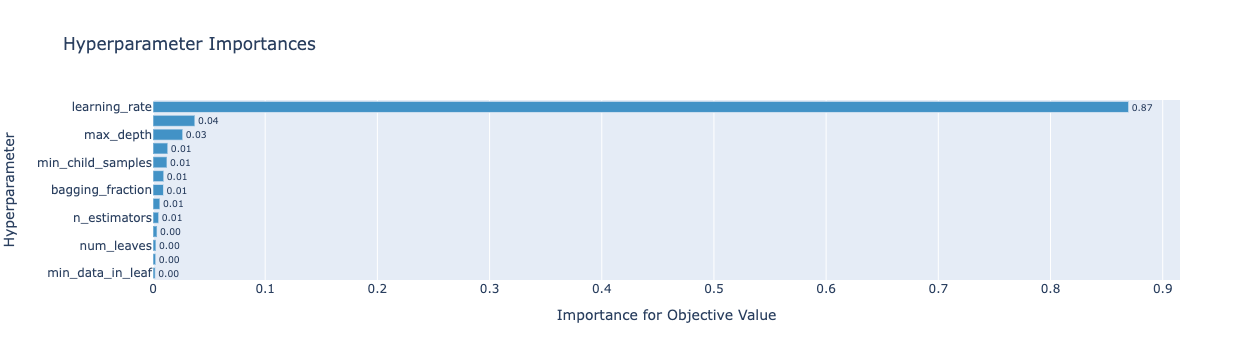

In [17]:
# Compare hyperparameter importances
plot_param_importances(study2)

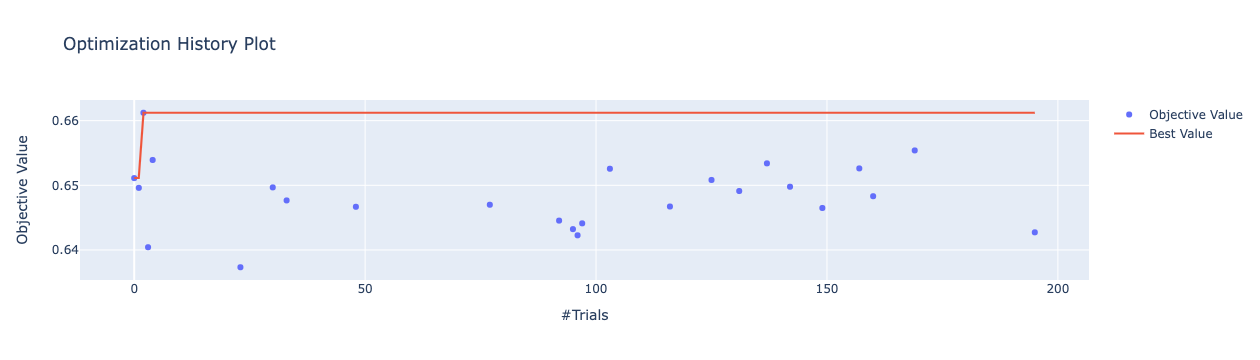

In [18]:
# Show optimization history
plot_optimization_history(study2)

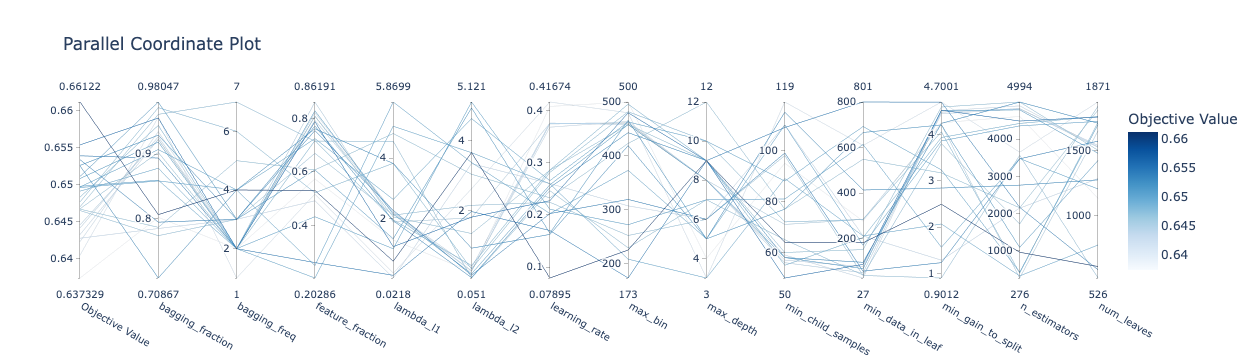

In [19]:
# Plot different combinations of hyperparams to see which in which ranges fared best
plot_parallel_coordinate(study2)

In [20]:
# Current
study2.best_value

0.6612195604594631

In [21]:
# Current
study2.best_params

{'num_leaves': 614,
 'feature_fraction': 0.5307008743241989,
 'bagging_fraction': 0.8065620181789359,
 'bagging_freq': 4,
 'min_child_samples': 64,
 'n_estimators': 966,
 'learning_rate': 0.07894599054803356,
 'max_depth': 9,
 'min_data_in_leaf': 182,
 'lambda_l1': 0.5796034286289232,
 'lambda_l2': 3.6647050559734553,
 'min_gain_to_split': 2.493233090827557,
 'max_bin': 225}

## Run Best Model

In [22]:
%%capture hide_output
# Select which round of hyperparam tuning to use
chosen_study = study2
# Create cv object
cv = StratifiedKFold(n_splits = 5, shuffle = True)
# Make empty array to store cv log loss in
cv_scores = np.empty(5)

# Split into K train and validation sets and iterate through them
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    # Split into training and validation CV sets
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train[train_idx], y_train[test_idx]

    # Convert data to proper LGB format
    train_data = lgb.Dataset(X_train_cv, label = y_train_cv, categorical_feature="auto")
    val_data = lgb.Dataset(X_test_cv, label = y_test_cv,  categorical_feature="auto")

    # Make callbacks to prevent trialling hyperparams that are obviously bad
    callbacks = [
                 # Callback to reduce model validation performance messages
                lgb.log_evaluation(period = 100),
                 # Early stoppping to prevent overfitting training data
                lgb.early_stopping(50)]

    # Training the model
    model = lgb.train(params = {**fixed_params, **chosen_study.best_params},  train_set = train_data,
                      valid_sets = val_data,   
                      callbacks = callbacks,
                      feval = cf.lgb_f1_score # use custom eval metric to optimize against
                     )

    # Get predictions
    preds = np.argmax(model.predict(X_test_cv), axis = 1)
    # Calculate F1 Score
    cv_scores[idx] = f1_score(y_test_cv, preds, average = "macro")


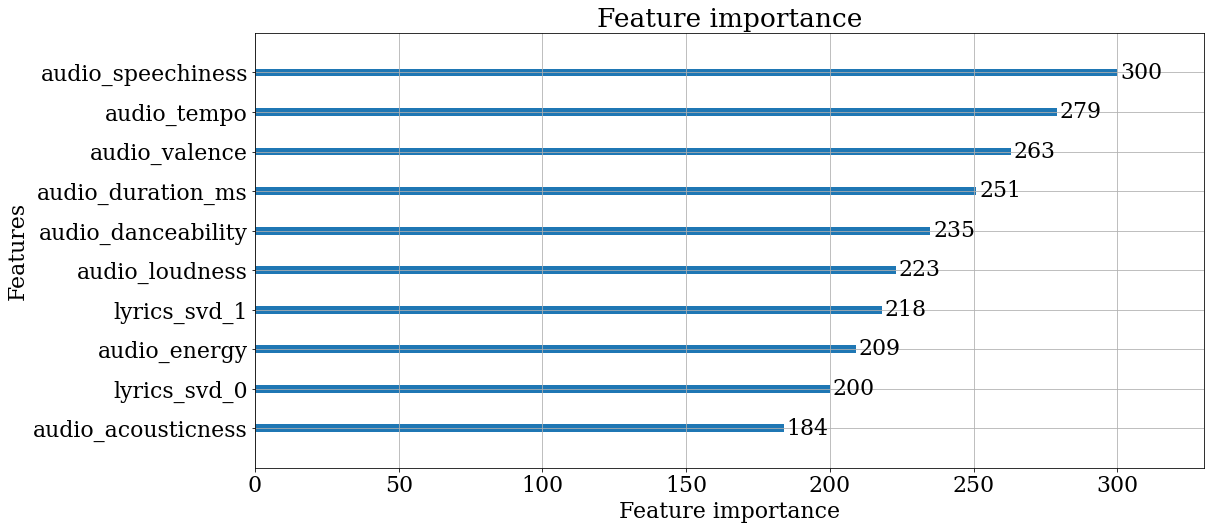

In [23]:
# Plot feature importance
lgb.plot_importance(model, max_num_features = 10);
# plt.tight_layout()
# plt.savefig("feature_importance.png")

In [24]:
# Current 1st round
np.mean(cv_scores)

0.6616108474331194

In [25]:
# Current 2nd round
np.mean(cv_scores)

0.6616108474331194

# Evaluation

In [26]:
# Get and save the various F1 errors
# Get train error
train_preds = model.predict(X_train)
train_predictions = np.argmax(train_preds, axis = 1)
train_error = f1_score(y_train, train_predictions, average = "macro")

# Store cv error
cv_error = np.mean(cv_scores)

# Generate test predictions for submission
test_preds = model.predict(X_test)
test_predictions = np.argmax(test_preds, axis = 1)
test_error = f1_score(y_test, test_predictions, average = "macro")
# # Generate submissions csv
# pd.DataFrame({"song_id":test_ids, # extracted in data load at top of notebook
#              "genre":label_encoder.inverse_transform(test_predictions)}).to_csv("results.csv", index=False)

# Store relevant results
results = pd.DataFrame({"pca_cutoff": n_components,
                        "reduction_method": reduction_method,
                        "train_error": train_error,
                        "cv_error": cv_error,
                        "test_error": test_error,
                        "n_trials": n_trials
                       }, index = [0])
# Save results
# Create file if it doesn't exist
if not os.path.exists("model_results.csv"):
    results.to_csv("model_results.csv", index = False)
# Append data if file does exist
else:
    existing_results = pd.read_csv("model_results.csv")
    pd.concat([existing_results, results]).to_csv("model_results.csv", index = False)

In [27]:
results

pca_cutoff reduction_method  train_error  cv_error  test_error  n_trials
0        1500              svd     0.885991  0.661611    0.649394       200